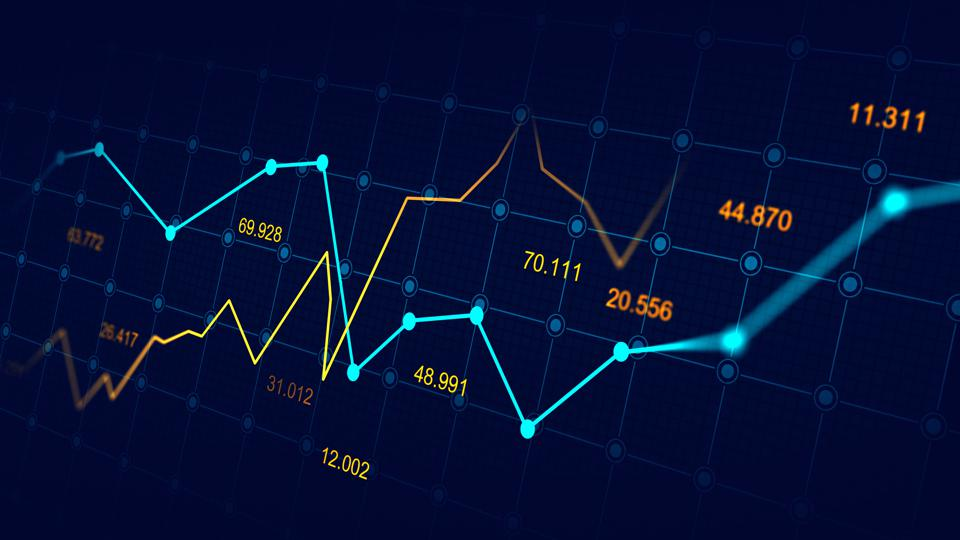

In [1]:
from IPython.display import Image
Image(filename ='E:/PIP_Devmallya/Week_2/Time_Series.jpg', width = 800, height = 200)

# Problem statement

Use Time Series forecasting to predict the volumes for the time frame which is missing in the dataset.

# Dataset 

This is a dataset with year and month stamps and volumes of sales of an item. The volumes are available for the timeframe between Jan of 2017 to October of 2021. The dataset is missing volume values Nov 2021 onwards. 

Your job is to forecast the volumes for Nov 2021 till Dec 2024. 

# Key pointers 

Check on the ‘Time Series partition’ concept and any feature engineering if applicable.

# 1. Import the Dependencies

In [3]:
import re
import itertools
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # In the presence of serial correlation, the Augmented Dickey-Fuller test can be used to look for a unit root in a univariate process.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Create a graph of the autocorrelation function. The delays are plotted on the horizontal axis, while the correlations are plotted on the vertical axis. Plot the partial autocorrelation function
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition using moving averages.
%matplotlib inline
sns.set(style='darkgrid')
warnings.filterwarnings('ignore')

    A time series is a collection of data points collected over a period of time. To put it another way, data is a function of time (f(t) = y). Hourly, daily, weekly, monthly, quarterly, and annual data points can be measured, as well as on smaller or bigger time scales such as seconds or decades.

# 2. Load the Dataset

In [4]:
df_train = pd.read_csv('E:/PIP_Devmallya/Week_2/Data_Volumes.csv')
df_train.head()

,Year,Month,Volumes,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,2017.0,January,28900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017.0,February,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017.0,March,35800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017.0,April,39000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017.0,May,33000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_train.columns

Index(['Year', 'Month', 'Volumes', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')

In [6]:
# Removing the unwanted columns
df_train = df_train.drop(columns = ['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'], axis = 1)

In [7]:
# Removing the unwanted rows
df_train = df_train.head(96)

In [8]:
df_train.head()

,Year,Month,Volumes
0,2017.0,January,28900.0
1,2017.0,February,30000.0
2,2017.0,March,35800.0
3,2017.0,April,39000.0
4,2017.0,May,33000.0


In [9]:
df_train.shape

(96, 3)

# 3. EDA and Data Preprocessing

In [10]:
# Information of the whole dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     96 non-null     float64
 1   Month    96 non-null     object 
 2   Volumes  58 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.4+ KB


In [11]:
# Statistical details of the dataframe
df_train.describe()

,Year,Volumes
count,96.000000,58.000000
mean,2020.500000,33574.655172
std,2.303316,3799.350570
min,2017.000000,26000.000000
25%,2018.750000,30677.250000
50%,2020.500000,32750.000000
75%,2022.250000,35873.500000
max,2024.000000,42075.000000


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     96 non-null     float64
 1   Month    96 non-null     object 
 2   Volumes  58 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.4+ KB


In [13]:
df_train.head()

,Year,Month,Volumes
0,2017.0,January,28900.0
1,2017.0,February,30000.0
2,2017.0,March,35800.0
3,2017.0,April,39000.0
4,2017.0,May,33000.0


In [14]:
df_train['Year'] = df_train['Year'].astype('int')

In [15]:
df_train.head()

,Year,Month,Volumes
0,2017,January,28900.0
1,2017,February,30000.0
2,2017,March,35800.0
3,2017,April,39000.0
4,2017,May,33000.0


In [16]:
# Changing all the string months names into integer months standerd numbers
df_train['Month'] = df_train['Month'].str.replace(r'January', '01')
df_train['Month'] = df_train['Month'].str.replace(r'February', '02')
df_train['Month'] = df_train['Month'].str.replace(r'March', '03')
df_train['Month'] = df_train['Month'].str.replace(r'April', '04')
df_train['Month'] = df_train['Month'].str.replace(r'May', '05')
df_train['Month'] = df_train['Month'].str.replace(r'June', '06')
df_train['Month'] = df_train['Month'].str.replace(r'July', '07')
df_train['Month'] = df_train['Month'].str.replace(r'August', '08')
df_train['Month'] = df_train['Month'].str.replace(r'September', '09')
df_train['Month'] = df_train['Month'].str.replace(r'October', '10')
df_train['Month'] = df_train['Month'].str.replace(r'November', '11')
df_train['Month'] = df_train['Month'].str.replace(r'December', '12')

In [17]:
df_train.head()

,Year,Month,Volumes
0,2017,01,28900.0
1,2017,02,30000.0
2,2017,03,35800.0
3,2017,04,39000.0
4,2017,05,33000.0


In [18]:
df_train['Year'] = df_train['Year'].astype('str')

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     96 non-null     object 
 1   Month    96 non-null     object 
 2   Volumes  58 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.4+ KB


In [20]:
# Join the Year and Month column
df_train['Month_years'] = df_train.Year + df_train.Month
df_train.head()

,Year,Month,Volumes,Month_years
0,2017,01,28900.0,201701
1,2017,02,30000.0,201702
2,2017,03,35800.0,201703
3,2017,04,39000.0,201704
4,2017,05,33000.0,201705


In [21]:
# Drop the column year and month columns after joining
df_train = df_train.drop(columns = ['Year', 'Month'], axis = 1)
df_train.head()

,Volumes,Month_years
0,28900.0,201701
1,30000.0,201702
2,35800.0,201703
3,39000.0,201704
4,33000.0,201705


In [22]:
df_train.tail()

,Volumes,Month_years
91,NaN,202408
92,NaN,202409
93,NaN,202410
94,NaN,202411
95,NaN,202412


In [23]:
# Change the column positions
first_column = df_train.pop('Month_years')
df_train.insert(0, 'Month_years', first_column)
df_train.head()

,Month_years,Volumes
0,201701,28900.0
1,201702,30000.0
2,201703,35800.0
3,201704,39000.0
4,201705,33000.0


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month_years  96 non-null     object 
 1   Volumes      58 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [25]:
# Convert the Month_years column into datetime format
df_train['Month_years'] = pd.to_datetime(df_train['Month_years'], format='%Y%m')

In [26]:
df_train.head()

,Month_years,Volumes
0,2017-01-01,28900.0
1,2017-02-01,30000.0
2,2017-03-01,35800.0
3,2017-04-01,39000.0
4,2017-05-01,33000.0


In [27]:
df_train.tail()

,Month_years,Volumes
91,2024-08-01,NaN
92,2024-09-01,NaN
93,2024-10-01,NaN
94,2024-11-01,NaN
95,2024-12-01,NaN


In [28]:
df_train.head(60)

,Month_years,Volumes
0,2017-01-01,28900.0
1,2017-02-01,30000.0
2,2017-03-01,35800.0
3,2017-04-01,39000.0
4,2017-05-01,33000.0
5,2017-06-01,30000.0
6,2017-07-01,34000.0
7,2017-08-01,32000.0
8,2017-09-01,36000.0
9,2017-10-01,31000.0


In [29]:
# Seperate the data into train for model building
df_train_main = df_train.iloc[:58]
df_train_main.tail()

,Month_years,Volumes
53,2021-06-01,38654.0
54,2021-07-01,35121.0
55,2021-08-01,34900.0
56,2021-09-01,38664.0
57,2021-10-01,34654.0


In [29]:
# Seperate the data into test for predictions
df_test = df_train.iloc[58:]
df_test.head()

,Month_years,Volumes
58,2021-11-01,NaN
59,2021-12-01,NaN
60,2022-01-01,NaN
61,2022-02-01,NaN
62,2022-03-01,NaN


In [30]:
df_test.tail()

,Month_years,Volumes
91,2024-08-01,NaN
92,2024-09-01,NaN
93,2024-10-01,NaN
94,2024-11-01,NaN
95,2024-12-01,NaN


In [31]:
df_train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month_years  58 non-null     datetime64[ns]
 1   Volumes      58 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [32]:
# We are setting the Month_year column  as index so that we can get monthwise average volumns
df_train_main.set_index('Month_years', inplace = True)
df_train_main.head()

,Volumes
Month_years,
2017-01-01,28900.0
2017-02-01,30000.0
2017-03-01,35800.0
2017-04-01,39000.0
2017-05-01,33000.0


In here the total number of volumes are the average of each days in a month

# 4. Plot the Time Series Data with ACF and PACF

    The plot data properties() function displays time series data, autocorrelation and partial autocorrelation graphs, and data point histograms. Plots data in a variety of ways, such as time series, autocorrelation, partial autocorrelation, and distribution plots.

In [33]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Volumes')
    plt.xlabel('Month_years')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=15);
    plot_pacf(data, ax=axes[0,1], lags=15);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

<h3>Stationarity in time series data</h3>

    We term a time series data that has trend and/or seasonality non-staionary. Why do we term non-stationary data non-stationary, and why are we afraid of it? The statistical features of data, such as mean, variance, and standard deviation, stay consistent across time if they are stationarized. Why should statistical qualities remain constant across time? Because we make statistical assumptions about the data throughout the model construction process (a good example would be OLS assumptions), and the model will only be capable of operating under those assumptions. When the statistical qualities of the data change, the model loses its ability to represent the real nature of the data since the data attributes have changed. As a result, our forecasting/prediction findings will be invalid. Changing the mean/variance will need fitting a new model, which may only be valid for a limited amount of time before being discarded and replaced. Take a look at how inefficient and unstable this procedure is.

    Before we can fit a model, we need to create time series data staionary. By modifying the data, we can make time series stationary. Differentiation is commonly used to make data steady.

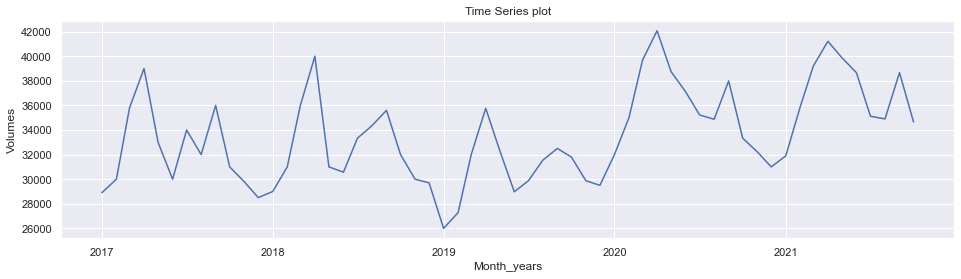

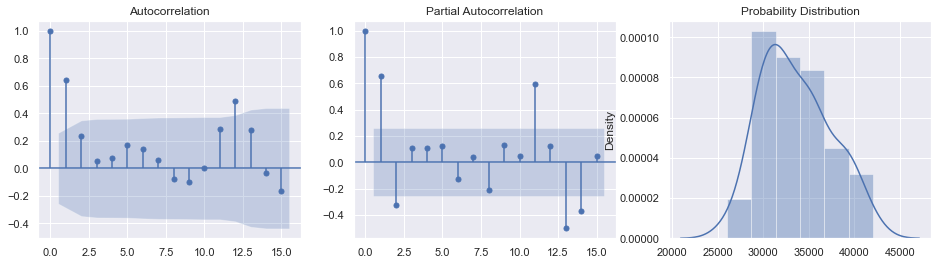

In [34]:
plot_data_properties(df_train_main)

    * So, how can we determine whether or not a time series data is staionary? 
    * The first method is to simply look at the time series plot and look for trends or seasonality
    * The second method is to divide the data into three sets and compute mean and variance for each set, then confirm whether the mean and variance for each set are significantly different. 
    * The third method is to utilise one of the statsmodels library's statistical tests. The most common is the enhanced Dickey Fuller test, in which the null hypohtesis H 0 = data is not stationary. The test statistic and P value are included in the ADF test result. If the P value is more than 0.05, the data is not stationary; otherwise, the null hypothesis is rejected and the data is said to be stationary. If it's less than 0.05 (p value 0.05), the data is stationary; if it's greater than 0.05, the data is not.
    Because it has trend and seasonality components, the original data is not stationary. The non-stationarity of the data is confirmed by the ADF test.
    We can also see autocorrelation at lags=12 and 24 are substantial in the Autocorrelation figure above. The autocorrelation plot depicts the relationship between time series data and its own lag values. For instance, autocorrelation at lag=1 reveals the relationship between y t and y t-1. corr(y t, y t-2) at lag=2. corr(y t, y t-12) at lag=12. So, in this figure, every data point at time t has a strong correlation with data at time t-12, indicating that a data point is associated with data from the previous month. The sample scatterplots below show a high degree of correlation. The significance level is shown by the blue coloured region on the autocorrelation plot. As a result, the correlation coefficients within the shaded area reveal just a weak association at those delays, and we don't consider them significant.
    The partial autocorrelation function (PACF) calculates a stationary time series' partial correlation with its own lagged values. PACF eliminates the impact of additional lags on the correlation between two lags, resulting in a pure correlation between two lags. The ARIMA model's AR(p) and MA(q) variables are ordered correctly using ACF and PACF. Look at the PACF plot for AR order p and select a lag value with a significant correlation factor before the correlations become negligible. Look at the ACF plot for MA order q and repeat. Remember that these values should only be obtained from the acf and pacf plots of stationary time series. As a result, we must make the data steady in our situation.

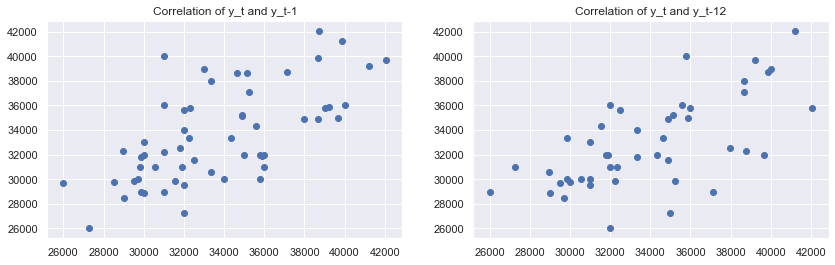

In [35]:
fig, axes = plt.subplots(1,2, squeeze=False);
fig.set_size_inches(14,4);
axes[0,0].scatter(x=df_train_main[1:], y=df_train_main.shift(1)[1:]);
axes[0,1].scatter(x=df_train_main[12:], y=df_train_main.shift(12)[12:]);
axes[0,0].set_title('Correlation of y_t and y_t-1');
axes[0,1].set_title('Correlation of y_t and y_t-12');

# 5. Ad Fuller test to check the stationarity if we need any transformations

    An augmented Dickey–Fuller test (ADF) in statistics and econometrics tests the null hypothesis that a unit root exists in a time series sample. The greater the rejection of the hypothesis that there is a unit root at whatever degree of confidence, the more negative it is.

In [36]:
def test_stationarity(data):
    p_val=adfuller(data['Volumes'])[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))

In [37]:
test_stationarity(df_train_main)

Time series data is not stationary. Adfuller test pvalue=0.8979328335510592


In [38]:
test_start_date = '2020-12-01'
training_data = df_train_main[:test_start_date]
test_data = df_train_main[test_start_date:]

In [39]:
training_data.head()

,Volumes
Month_years,
2017-01-01,28900.0
2017-02-01,30000.0
2017-03-01,35800.0
2017-04-01,39000.0
2017-05-01,33000.0


Time Series Decomposition to see trend, seasonality & residuals¶

    * Data from a time series Trend, Cycles, Seasonality, and Residuals make up the variable Y. Obviously, you could run into a time series that lacks a Trend, Cycles, or Seasonality. As a result, it's up to you to figure out what the components of Y are. Long-term upward or downward movement is referred to be a trend. Economic fluctuations cause periodic variation, which is referred to as a cycle. It's not the same as seasonal fluctuation. The fluctuation in the autoregressive component of time series data is referred to as a cycle. Cycles occur over longer periods of time, such as every 6-10 years, whereas seasonal fluctuation happens over shorter periods of time. Seasonality is a term used to describe the variance in data produced by seasonal factors. Summer sales of ice cream are high, whereas sales of heating oil are high in the winter but low in the summer. Residuals are the remaining components after all of the other components have been computed and eliminated from the time series data. It is dispersed at random. N is next (0,1). 
    * The seasonal decompose function in the Statsmodels package decomposes Y into Trend, Seasonality, and Residuals. Although it is a basic decomposition approach, it is quite straightforward in practise and works well for time series data with evident T, S, and R. I'd want to discuss the interplay between these components before discussing the graphs below. The additive or multiplicative form of time series data Y is possible. Time series Y is created in additive form by the sum of time series components T,S,C,R: Y = T + C + S + R.
    * We divide time series data into three categories: Trend, Seasonal Components, and Residuals. To breakdown and visualise the components, we utilise the statsmodels seasonal decompose() method.

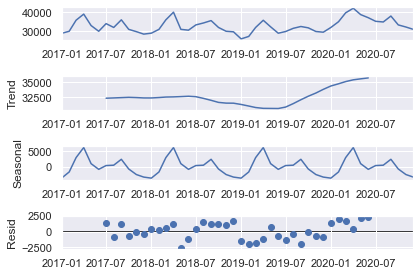

In [40]:
ts_decomp = sm.tsa.seasonal_decompose(training_data, model = 'additive')
ts_decomp.plot()
plt.show()

    Seasonality can also be seen in different ways. For example, I plotted volumes for each year in the graph below. And, as you can see, each year follows a similar trend with minor variations. Volumes are higher in the summer and lower in the winter.

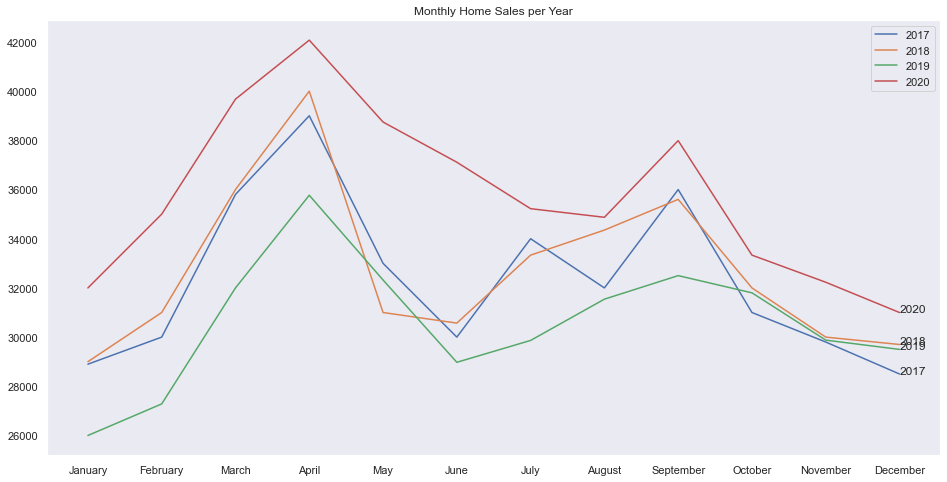

In [41]:
plt.figure(figsize=(16,8))
plt.grid(which='both')
years = int(np.round(len(training_data)/12))
for i in range(years):
    index = training_data.index[i*12:(i+1)*12]
    plt.plot(training_data.index[:12].month_name(),training_data.loc[index].values);
    plt.text(y=training_data.loc[index].values[11], x=11, s=training_data.index.year.unique()[i]);
plt.legend(training_data.index.year.unique(), loc=0);
plt.title('Monthly Home Sales per Year');

# 6. Data transformation: Log transformation and differencing

    (S) ARIMA models, like Linear Regression, are linear models. A linear model SARIMA cannot be fitted to data generated by a process Y = TSR. Before we can fit a linear model, we need to make Y linear. As you may know from math, log(a*b) = log(a) + log(b) = log(a) + log(b) = log(a) + log (b). To make the data linear, we must logtransform it. log(Y) = log(T) + log(S) + log(S) + log(Y) (R). The log transformation smoothes and linearizes data. In certain cases, log transformation can make data steady on its own, but this is not the case here. To eliminate trend, we must use 1st order integration (differencing) and 12th order integration to remove seasonality from the data. The series will thereafter become stagnant.

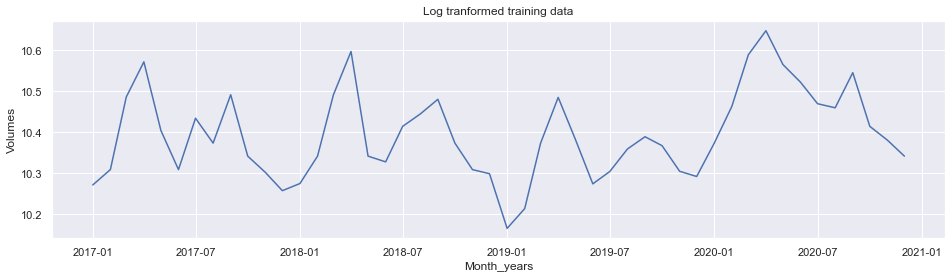

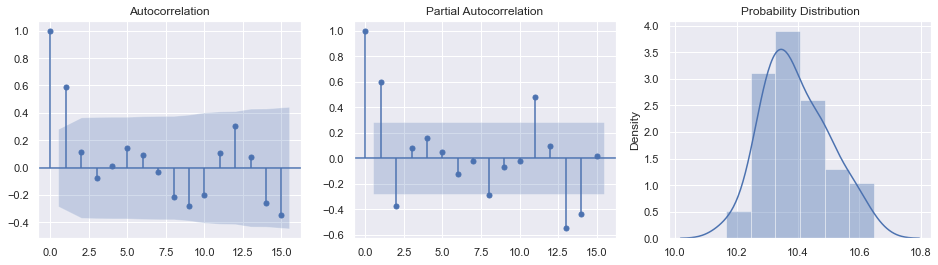

In [42]:
log_transformed_data = np.log(training_data)
plot_data_properties(log_transformed_data, 'Log tranformed training data')

In [43]:
test_stationarity(log_transformed_data)

Time series data is stationary. Adfuller test pvalue=0.0003505727007353503


    Differencing is a fundamental data transformation procedure. The difference between y at time=t and y at time=t-x is the difference. y t - y t-1 = diff 1 Due to the removal of time series components from the data, differencing makes the data stable and leaves residuals.

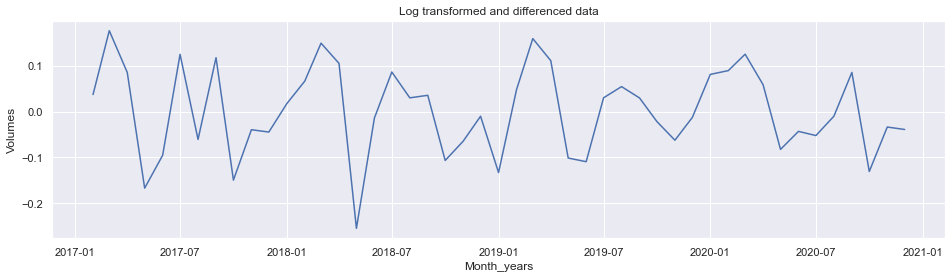

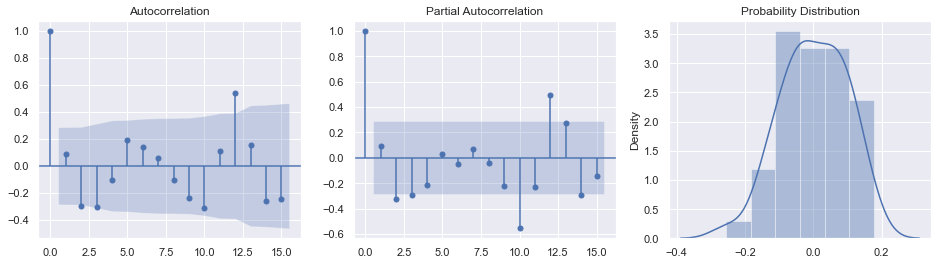

In [44]:
logged_diffed_data = log_transformed_data.diff()[1:]
plot_data_properties(logged_diffed_data, 'Log transformed and differenced data')

In [45]:
test_stationarity(logged_diffed_data)

Time series data is stationary. Adfuller test pvalue=0.000648192053537659


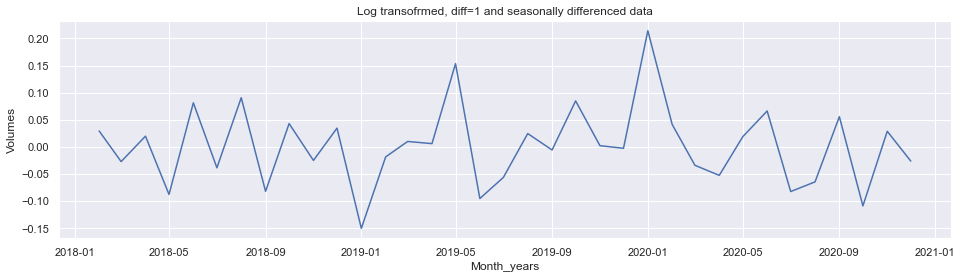

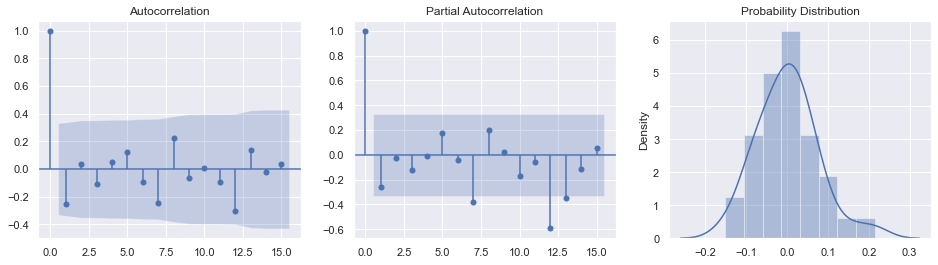

In [46]:
seasonally_diffed_data = logged_diffed_data.diff(12)[12:]
plot_data_properties(seasonally_diffed_data, 'Log transofrmed, diff=1 and seasonally differenced data')

In [47]:
test_stationarity(seasonally_diffed_data)

Time series data is stationary. Adfuller test pvalue=1.1068046959226684e-10


    The data has come to a halt. The histogram of data resembles that of a Normal Distribution. To ensure that the data is regularly distributed, I utilised the Shapiro normality test. It's one of the stationary data's qualities. So, why does differencing cause the data to become stationary? You can only acquire the minor changes in y between time steps through differencing. These changes are often regularly distributed with constant mean and variance, as is the case with stationary data.

In [48]:
from scipy.stats import shapiro
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(np.round(p_value,3)))

In [49]:
shapiro_normality_test(seasonally_diffed_data.Volumes)

Data follows normal distribution: X~N(0.001, 0.073)
Shapiro test p_value=0.607


# 7. Fitting the model

    We may now proceed to the model fitting step because the modified data has become stationary. We have a brief discussion regarding SARIMA before. This is the model on which I'd want to eloborate. SARIMA is a subset of the ARIMA family that can model time series data with seasonal components. To summarise what ARIMA stands for: AR - Autonomous Robotics Time series data is regressed on its lagged values in a regressive model. The time series itself becomes the dependent variable, while the lag values become independent variables. y = a 0 + a 1y t-1 + a 2y t-2, a k*y t-k, a k*y t-k. The most important challenge here is to decide how many independent variables to employ. Please do not be confused by the terms time series or lagged values; they are just independent variables.
    
    You might use linear regression to look at the correlation between independent and dependent variables and chose highly correlated variables as your features. You should do the same here. However, you may utilise PACF to decide how many lags to employ instead of calculating correlation between lagged values and the target variable. At lag=1, the autocorrelation of stationary data is large, whereas at lag=2, the autocorrelation is minimal. AR order p should ideally be 1. However, we shall see during the model selection process that we must perform a parameter search on p in order to discover the best value. Initial guesses, on the other hand, will choose which values to seek in the grid. p = [0-2] would suffice in this situation.
    
    I - Integration Order: In other words, how many times have you differed the data? Once upon a time, we had it d=1. When you set parameter d=1, don't forget to fit the model to non-differenced data, since the method will do so. d=0 if we fit on stationary data and don't need to differenciate. Just to make the data steady, we need to use differencing.
    
    MA - Moving Average model: Time series is y regressed on resdiuals w. y = a_0 + a_1w1 + a_2w2 + .... + a_k*wk Look at ACF plot to determine the order (q) of MA part of ARIMA model. ACF suggest order q=1 for MA part of the ARIMA model. However, we should do grid search to find an optimal model. I suggest to look at values q=[0-2].
    
    Seasonal model - Seasonality, along with AR and MA, must be simulated, and it contains four parameters (P,D,Q,s). Consider P, D, and Q parameters to be comparable to AR, I, and MA parameters, but solely for the series' seasonal component. P can be determined by looking at PACF, and Q can be determined by looking at ACF. D is the number of seasonal differences that have been taken. s determines the frequency of the seasonal impact. P = 1 - we have a significant correlation at lag=12, but it isn't strong enough, thus we may not require an AR variable in the model. As a result, we should conduct a grid search on P = [0-2].
    
    D=1 - we only make a seasonal difference once.

    According to the ACF plot, we find a high association at lag=12. Let's also do a grid search on the parameter Q=[0-2].

    s=12 - frequency of seasonality, once per 12 months.

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

    The Best sarima model function runs a grid search on the (p,d,q) and (P,D,Q,s) parameters to determine the best model based on statistical metrics like AIC, BIC, and HQIC. A model with a lower AIC, BIC, and HQIC is a better model. Overfitting is penalised by these measures, which reward goodness-of-fit (log-likelihood). Overfitting occurs when there are several lagged characteristics, as in our example. The tradeoff between probability and degrees of freedom is balanced by AIC, BIC, and HQIC. This trait may be seen in their formula. I won't get into the technicalities of other measures, but I will provide an example below to demonstrate why I believe AIC is the best statistic to use: Formula for AIC: k denotes the number of estimated parameters in the model, or features (lag terms). The likelihood function's maximum value is L. 2k - 2ln = AIC (L).

In [51]:
def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models  

    We're fitting the model on log transformed data since we've set the d=1 and D=1 parameters, and the model will handle the differencing for us. With the parameters we established above, we examined SARIMA models. The best model, or the one with the lowest AIC, BIC, and HQIC, is shown in the table below. According to the best model, we don't require AR features, simply MA and seasonal MA characteristics.
    
    Because ARIMA and SARIMA models are based on OLS, all OLS assumptions apply to this family of models. I'm not going to go into detail about these assumptions right now. It is the subject of a separate article. However, we must verify that our model is consistent with those assumptions. Coeficients have a P value of 0.05. The residuals are distributed normally, with a high concentration around 0. The residuals are homoscedastic and stationary. There is no association between residuls in terms of order.

In [52]:
best_model, models = best_sarima_model(train_data=log_transformed_data,p=range(3),q=range(3),P=range(3),Q=range(3))

Best model so far: SARIMA(0, 1, 0, 0, 1, 0, 12) AIC:-82.0 BIC:-80.0 HQIC:-81.0 resid:603.046
Best model so far: SARIMA(0, 1, 0, 0, 1, 1, 12) AIC:-87.0 BIC:-84.0 HQIC:-86.0 resid:603.046
Best model so far: SARIMA(0, 1, 1, 0, 1, 1, 12) AIC:-88.0 BIC:-84.0 HQIC:-87.0 resid:603.047


                                     SARIMAX Results                                      
Dep. Variable:                            Volumes   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  47.199
Date:                            Thu, 23 Dec 2021   AIC                            -88.398
Time:                                    17:48:08   BIC                            -83.732
Sample:                                01-01-2017   HQIC                           -86.787
                                     - 12-01-2020                                         
Covariance Type:                              opg                                 

    To determine how well the model works, MAPE (mean absolute percentage error) will be used. SARIMA (order=(0,1,2), seasonal order=) is the best model we have (0,1,1,12). In time series analysis, I favour MAPE error since it is more intuitive.

In [53]:
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values)  

In [54]:
preds_best=np.exp(best_model.predict(start=test_start_date, end='2021-10-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,preds_best),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,preds_best),2)))

MAPE:3.87%
MAE:1452.68


    Compare the anticipated values to the original data to see what happens. The model is successful in capturing the seasonal influence, but not in capturing the trend. The volume trend is decreasing, but the model is unable to reflect it properly. It is aware that volumes are decreasing, but this is due to seasonal effects.

In [55]:
df_train_main.shape

(58, 1)

In [56]:
training_data.shape

(48, 1)

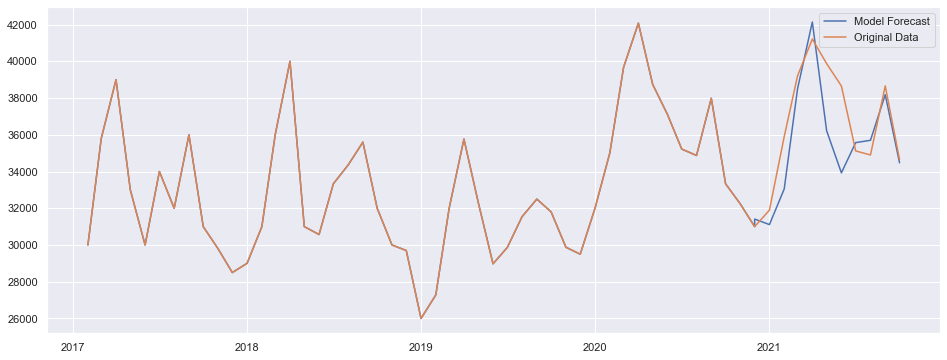

In [57]:
model_data = training_data.values[1:].reshape(47) - best_model.resid[1:]
model_data = pd.concat((model_data,preds_best))
plt.figure(figsize=(16,6));
plt.plot(model_data);
plt.plot(df_train_main[1:]);
plt.legend(['Model Forecast','Original Data']);

# 8. Predictions on Test data from Nov 2021 till Dec 2024

In [58]:
On_test_model = SARIMAX(endog=log_transformed_data,order=(1,1,2), seasonal_order=(1,1,2,12),
                                        enforce_invertibility=False).fit()
On_test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Volumes   No. Observations:                   48
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                  47.236
Date:                            Thu, 23 Dec 2021   AIC                            -80.472
Time:                                    17:48:11   BIC                            -69.585
Sample:                                01-01-2017   HQIC                           -76.714
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0372      4.854      0.008      0.994      -9.477       9.552
ma.L1         -0.3454      4.775     -0.072      0.942      -9.705       9.014
ma.L2         -0.0303      1.633     -0.019      0.985      -3.231       3.171
ar.S.L12      -0.3790     73.764     -0.005      0.996    -144.954     144.196
ma.S.L12      -0.6169     82.718     -0.007      0.994    -162.741     161.507
ma.S.L24      -0.3849     70.110     -0.005      0.996    -137.799     137.029
sigma2         0.0025      0.022      0.111      0.912      -0.041       0.046
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.90   Prob(JB):                         0.95
Heteroskedasticity (H):               1.73   Skew:                             0.12
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.45e+17. Standard errors may be unstable.
"""

In [59]:
On_test_model_pred = np.exp(On_test_model.predict(start='2021-11-01', end='2024-12-01', dynamic=True, typ='levels'))
print('Future Predictions:', On_test_model_pred)

Future Predictions: 2021-11-01    32534.741285
2021-12-01    31683.312666
2022-01-01    31406.518140
2022-02-01    33365.394571
2022-03-01    38876.116727
2022-04-01    42549.335682
2022-05-01    36570.269420
2022-06-01    34250.743744
2022-07-01    35919.754059
2022-08-01    36045.842143
2022-09-01    38554.076388
2022-10-01    34810.739480
2022-11-01    33112.885555
2022-12-01    32249.770560
2023-01-01    31979.982583
2023-02-01    33977.957243
2023-03-01    39586.298816
2023-04-01    43322.083690
2023-05-01    37238.132211
2023-06-01    34881.017949
2023-07-01    36571.285088
2023-08-01    36697.015046
2023-09-01    39253.344933
2023-10-01    35436.376655
2023-11-01    33709.754675
2023-12-01    32829.753036
2024-01-01    32550.499837
2024-02-01    34582.833200
2024-03-01    40292.385185
2024-04-01    44096.553663
2024-05-01    37902.410988
2024-06-01    35501.408049
2024-07-01    37225.385543
2024-08-01    37354.384747
2024-09-01    39955.433148
2024-10-01    36072.407589
2024-11-

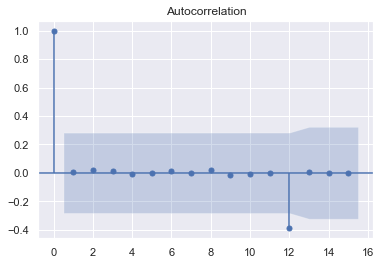

In [60]:
plot_acf(On_test_model.resid, lags=15);

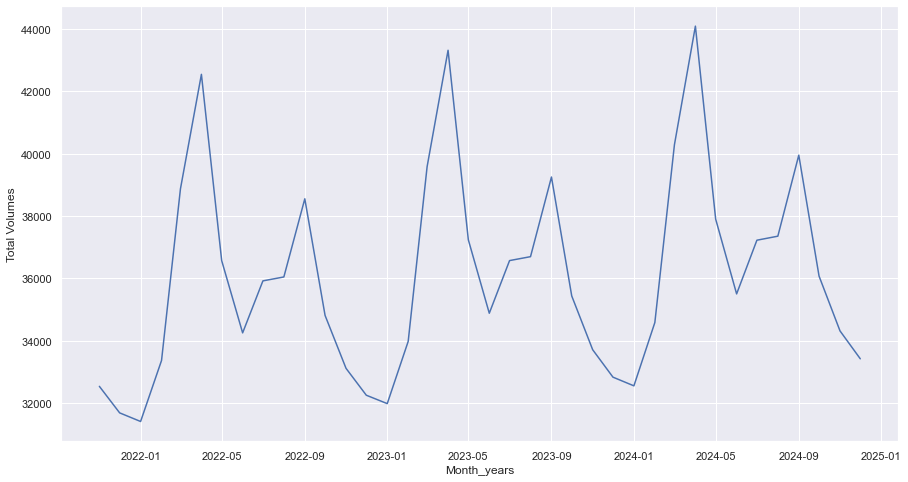

In [61]:
plt.figure(figsize=(15,8))
plt.xlabel("Month_years")
plt.ylabel("Total Volumes")
plt.plot(On_test_model_pred)

In [62]:
df_train_main.head()

,Volumes
Month_years,
2017-01-01,28900.0
2017-02-01,30000.0
2017-03-01,35800.0
2017-04-01,39000.0
2017-05-01,33000.0


In [63]:
df_future = pd.DataFrame(On_test_model_pred)
df_future.head()

,predicted_mean
2021-11-01,32534.741285
2021-12-01,31683.312666
2022-01-01,31406.518140
2022-02-01,33365.394571
2022-03-01,38876.116727


In [64]:
df_final_1 = pd.concat([df_train_main, df_future])
df_final_1.head()

,Volumes,predicted_mean
2017-01-01,28900.0,NaN
2017-02-01,30000.0,NaN
2017-03-01,35800.0,NaN
2017-04-01,39000.0,NaN
2017-05-01,33000.0,NaN


In [65]:
df_final_1.tail()

,Volumes,predicted_mean
2024-08-01,NaN,37354.384747
2024-09-01,NaN,39955.433148
2024-10-01,NaN,36072.407589
2024-11-01,NaN,34314.121357
2024-12-01,NaN,33418.855222


<AxesSubplot:>

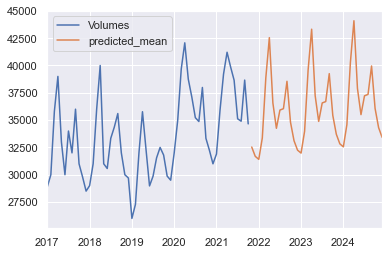

In [66]:
df_final_1.plot()

# 9. Submissions

In [67]:
df_future.rename(columns = {'predicted_mean': 'Volumes'}, inplace = True)

In [68]:
df_future.head()

,Volumes
2021-11-01,32534.741285
2021-12-01,31683.312666
2022-01-01,31406.518140
2022-02-01,33365.394571
2022-03-01,38876.116727


In [69]:
df_future.index.name = 'Month_years'

In [70]:
df_future.head()

,Volumes
Month_years,
2021-11-01,32534.741285
2021-12-01,31683.312666
2022-01-01,31406.518140
2022-02-01,33365.394571
2022-03-01,38876.116727


In [71]:
df_final_2 = pd.concat([df_train_main, df_future])
df_final_2

,Volumes
Month_years,
2017-01-01,28900.000000
2017-02-01,30000.000000
2017-03-01,35800.000000
2017-04-01,39000.000000
2017-05-01,33000.000000
...,...
2024-08-01,37354.384747
2024-09-01,39955.433148
2024-10-01,36072.407589


In [72]:
df_final_2.reset_index(level=0, inplace=True)
df_final_2

,Month_years,Volumes
0,2017-01-01,28900.000000
1,2017-02-01,30000.000000
2,2017-03-01,35800.000000
3,2017-04-01,39000.000000
4,2017-05-01,33000.000000
...,...,...
91,2024-08-01,37354.384747
92,2024-09-01,39955.433148
93,2024-10-01,36072.407589
94,2024-11-01,34314.121357


In [73]:
df_final_2['Month_years'] = pd.to_datetime(df_final_2.Month_years).dt.to_period('m')

In [74]:
df_final_2.head()

,Month_years,Volumes
0,2017-01,28900.0
1,2017-02,30000.0
2,2017-03,35800.0
3,2017-04,39000.0
4,2017-05,33000.0


In [75]:
df_final_2.tail()

,Month_years,Volumes
91,2024-08,37354.384747
92,2024-09,39955.433148
93,2024-10,36072.407589
94,2024-11,34314.121357
95,2024-12,33418.855222


In [76]:
df_final_2['Month_years'] = df_final_2['Month_years'].astype('str')

In [77]:
df_final_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month_years  96 non-null     object 
 1   Volumes      96 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [78]:
new = df_final_2["Month_years"].str.split("-", n = 1, expand = True)

In [79]:
df_final_2["Year"]= new[0]

In [80]:
df_final_2["Month"]= new[1]

In [81]:
df_final_2.head()

,Month_years,Volumes,Year,Month
0,2017-01,28900.0,2017,01
1,2017-02,30000.0,2017,02
2,2017-03,35800.0,2017,03
3,2017-04,39000.0,2017,04
4,2017-05,33000.0,2017,05


In [82]:
df_final_2.tail()

,Month_years,Volumes,Year,Month
91,2024-08,37354.384747,2024,08
92,2024-09,39955.433148,2024,09
93,2024-10,36072.407589,2024,10
94,2024-11,34314.121357,2024,11
95,2024-12,33418.855222,2024,12


In [83]:
df_final_2 = df_final_2.drop(columns = ['Month_years'], axis = 1)
df_final_2.head()

,Volumes,Year,Month
0,28900.0,2017,01
1,30000.0,2017,02
2,35800.0,2017,03
3,39000.0,2017,04
4,33000.0,2017,05


In [84]:
# Change the Month column positions
first_column_1 = df_final_2.pop('Month')
df_final_2.insert(0, 'Month', first_column_1)
df_final_2.head()

,Month,Volumes,Year
0,01,28900.0,2017
1,02,30000.0,2017
2,03,35800.0,2017
3,04,39000.0,2017
4,05,33000.0,2017


In [85]:
df_final_2.tail()

,Month,Volumes,Year
91,08,37354.384747,2024
92,09,39955.433148,2024
93,10,36072.407589,2024
94,11,34314.121357,2024
95,12,33418.855222,2024


In [86]:
# Change the Year column positions
first_column_2 = df_final_2.pop('Year')
df_final_2.insert(0, 'Year', first_column_2)
df_final_2.head()

,Year,Month,Volumes
0,2017,01,28900.0
1,2017,02,30000.0
2,2017,03,35800.0
3,2017,04,39000.0
4,2017,05,33000.0


In [87]:
df_final_2.tail()

,Year,Month,Volumes
91,2024,08,37354.384747
92,2024,09,39955.433148
93,2024,10,36072.407589
94,2024,11,34314.121357
95,2024,12,33418.855222


In [88]:
df_final_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     96 non-null     object 
 1   Month    96 non-null     object 
 2   Volumes  96 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.4+ KB


In [89]:
# Changing all the integer months names into strings months standerd numbers
df_final_2['Month'] = df_final_2['Month'].replace(r'01', 'January')
df_final_2['Month'] = df_final_2['Month'].replace(r'02', 'February')
df_final_2['Month'] = df_final_2['Month'].replace(r'03', 'March')
df_final_2['Month'] = df_final_2['Month'].replace(r'04', 'April')
df_final_2['Month'] = df_final_2['Month'].replace(r'05', 'May')
df_final_2['Month'] = df_final_2['Month'].replace(r'06', 'June')
df_final_2['Month'] = df_final_2['Month'].replace(r'07', 'July')
df_final_2['Month'] = df_final_2['Month'].replace(r'08', 'August')
df_final_2['Month'] = df_final_2['Month'].replace(r'09', 'September')
df_final_2['Month'] = df_final_2['Month'].replace(r'10', 'October')
df_final_2['Month'] = df_final_2['Month'].replace(r'11', 'November')
df_final_2['Month'] = df_final_2['Month'].replace(r'12', 'December')

In [90]:
df_final_2.head()

,Year,Month,Volumes
0,2017,January,28900.0
1,2017,February,30000.0
2,2017,March,35800.0
3,2017,April,39000.0
4,2017,May,33000.0


In [91]:
df_final_2.tail()

,Year,Month,Volumes
91,2024,August,37354.384747
92,2024,September,39955.433148
93,2024,October,36072.407589
94,2024,November,34314.121357
95,2024,December,33418.855222


In [92]:
df_final_2.to_csv('E:/PIP_Devmallya/Week_2/submissions_2.csv', index = False)
df_final_2.head()

,Year,Month,Volumes
0,2017,January,28900.0
1,2017,February,30000.0
2,2017,March,35800.0
3,2017,April,39000.0
4,2017,May,33000.0


In [93]:
df_final_2.tail()

,Year,Month,Volumes
91,2024,August,37354.384747
92,2024,September,39955.433148
93,2024,October,36072.407589
94,2024,November,34314.121357
95,2024,December,33418.855222


# 10. End

# Techniques to Explore

## ARIMA, ARIMAX, SARIMA & SARIMAX

    ARIMA models are a type of statistical model that may be used to analyse and forecast time series data.
    AutoRegressive Integrated Moving Average (ARIMA) is an abbreviation for AutoRegressive Integrated Moving Average. It's a more complex version of the AutoRegressive Moving Average, with the addition of integration.
    This abbreviation is descriptive, summarising the model's major features. They are, in a nutshell:

    AR stands for autoregression. The dependent relationship between an observation and a set of lagged observations is used in this model.
    I stands for "integrated." To make the time series steady, differencing raw observations (e.g. subtracting an observation from an observation from the preceding time step) is used.
    MA stands for Moving Average. The dependence between an observation and a residual error from a moving average model applied to lagged data is used in this model.
    
    Each of these elements is explicitly described as a parameter in the model. ARIMA(p,d,q) is a standard notation in which the parameters are replaced with integer values to immediately identify the ARIMA model being utilised.

    The following are the parameters of the ARIMA model:

    p: The lag order, or the number of lag observations incorporated in the model.
    d: The degree of differencing is the number of times the raw observations are differenced.
    q: The order of moving average, also known as the size of the moving average window.
    
    A parameter with a value of 0 indicates that that piece of the model should not be used. This allows the ARIMA model to mimic the functionality of an ARMA model or even a basic AR, I, or MA model.
    
    The names ARMAX and ARIMAX come as extensions of the ARMA and ARIMA respectively. The X added to the end stands for “exogenous”. In other words, it suggests adding a separate different outside variable to help measure our endogenous variable.
    
    X, on the other hand, is the exogenous variable, and it might be any variable we care about.

    It might be a time-varying metric such as inflation or the price of a separate index. Alternatively, a categorical variable that distinguishes the different days of the week. For the unique holiday occasions, it can also be a Boolean accounting. Finally, it might refer to a mixture of many external circumstances.

    The concept is that any additional variable or factors that potentially influence pricing can be used as long as we get the data.

    Exogenous variables in our regression are such external influences.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
df_train_main.head()

,Month_years,Volumes
0,2017-01-01,28900.0
1,2017-02-01,30000.0
2,2017-03-01,35800.0
3,2017-04-01,39000.0
4,2017-05-01,33000.0


<AxesSubplot:>

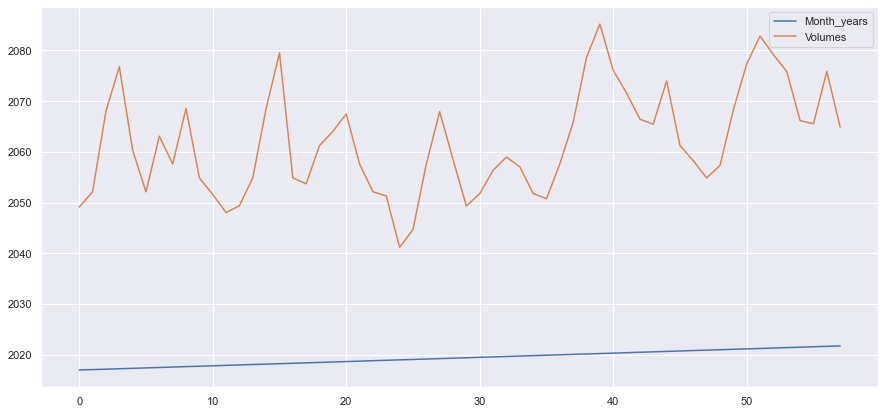

In [31]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df_train_main.plot()

    If we look at the graph above, we can see that there is a tendency that there are times when volumes are high and times when they are low. As a result, we can observe that the data is seasonal. The first step in ARIMA is to determine if the data is stationary or non-stationary. If the data is non-stationary, we shall attempt to make it stationary before proceeding with the processing.

In [33]:
df_train_main.isnull().sum()

Month_years    0
Volumes        0
dtype: int64

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
test_result=adfuller(df_train_main['Volumes'])

    The null hypothesis will be used to determine the nature of the data.

    The null hypothesis is H0: Unless it can be proven to be false beyond a reasonable doubt, it is a statement about the population that is either believed to be true or used to make an argument.

    H1: The alternative hypothesis: It's a population assertion that contradicts H0, and it's what we come to after we reject H0.

    Ho: It's a non-stationary object.
    #H1: It isn't moving.

In [37]:
def adfuller_test(Volumes):
    result=adfuller(Volumes)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
        else:
            print("weak evidence against null hypothesis,indicating it is non-stationary ")

    After running the above code we will get P-value,

In [38]:
adfuller_test(df_train_main['Volumes'])

ADF Test Statistic : -0.46895950295361777
weak evidence against null hypothesis,indicating it is non-stationary 
p-value : 0.8979328335510592
weak evidence against null hypothesis,indicating it is non-stationary 
#Lags Used : 10
weak evidence against null hypothesis,indicating it is non-stationary 
Number of Observations : 47
weak evidence against null hypothesis,indicating it is non-stationary 


    Here P-value is 0.89 which is greater than 0.05, which means data is accepting the null hypothesis, which means data is non-stationary.

In [39]:
df_train_main['Volumes First Difference'] = df_train_main['Volumes'] - df_train_main['Volumes'].shift(1)
df_train_main['Seasonal First Difference']=df_train_main['Volumes']-df_train_main['Volumes'].shift(12)
df_train_main.head()

,Month_years,Volumes,Volumes First Difference,Seasonal First Difference
0,2017-01-01,28900.0,NaN,NaN
1,2017-02-01,30000.0,1100.0,NaN
2,2017-03-01,35800.0,5800.0,NaN
3,2017-04-01,39000.0,3200.0,NaN
4,2017-05-01,33000.0,-6000.0,NaN


In [40]:
# Again testing if data is stationary
adfuller_test(df_train_main['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.343801673282814
weak evidence against null hypothesis,indicating it is non-stationary 
p-value : 0.158229806967777
weak evidence against null hypothesis,indicating it is non-stationary 
#Lags Used : 0
weak evidence against null hypothesis,indicating it is non-stationary 
Number of Observations : 45
weak evidence against null hypothesis,indicating it is non-stationary 


    Here P-value is 0.15, So data is stationary.

<AxesSubplot:>

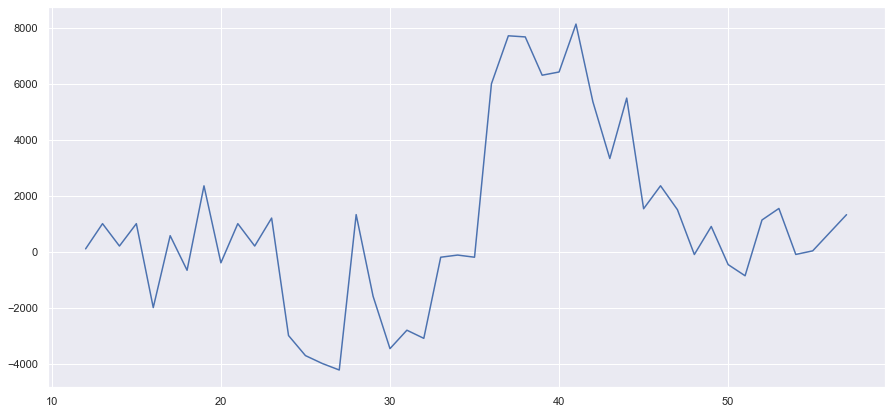

In [41]:
df_train_main['Seasonal First Difference'].plot()

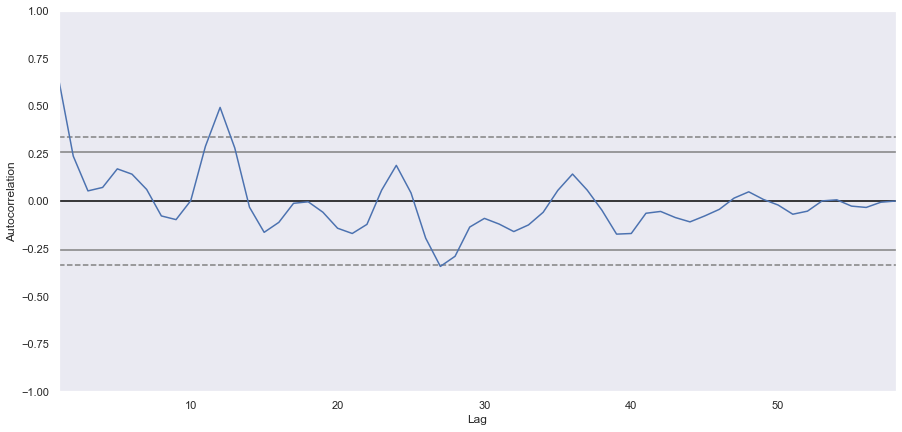

In [43]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_train_main['Volumes'])
plt.show()

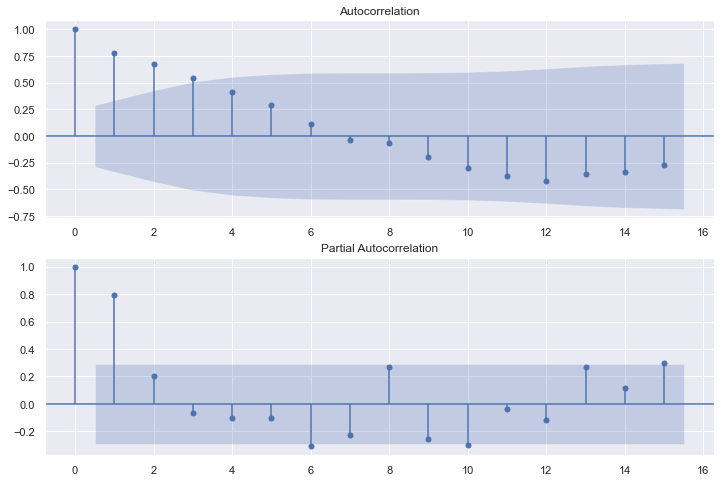

In [46]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train_main['Seasonal First Difference'].dropna(),lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train_main['Seasonal First Difference'].dropna(),lags=15,ax=ax2)

In [47]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df_train_main['Volumes'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Volumes   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -537.875
Method:                       css-mle   S.D. of innovations           2977.519
Date:                Fri, 24 Dec 2021   AIC                           1083.750
Time:                        11:55:47   BIC                           1091.922
Sample:                             1   HQIC                          1086.926
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              69.5994    445.025      0.156      0.876    -802.633     941.832
ar.L1.D.Volumes    -0.7715      0.100     -7.680      0.000      -0.968      -0.575
ma.L1.D.Volumes     1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2962           +0.0000j            1.2962            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In [49]:
df_train_main.tail()

,Month_years,Volumes,Volumes First Difference,Seasonal First Difference
53,2021-06-01,38654.0,-1222.0,1543.0
54,2021-07-01,35121.0,-3533.0,-101.0
55,2021-08-01,34900.0,-221.0,28.0
56,2021-09-01,38664.0,3764.0,675.0
57,2021-10-01,34654.0,-4010.0,1321.0


<AxesSubplot:>

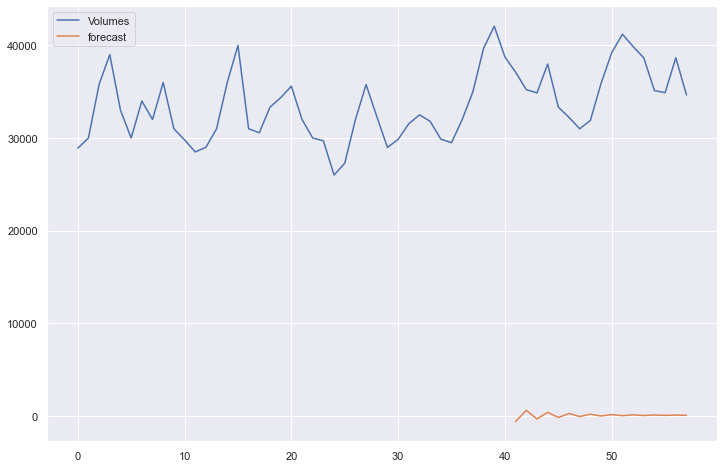

In [50]:
df_train_main['forecast']=model_fit.predict(start=41,end=57,dynamic=True)
df_train_main[['Volumes','forecast']].plot(figsize=(12,8))

    SARIMA (Seasonal ARIMA) is a modification of ARIMA that explicitly allows univariate time series data with a seasonal component.

    It includes three new hyperparameters for the seasonal component of the series: autoregression (AR), differencing (I), and moving average (MA), as well as an extra parameter for the seasonality period.
    
    The ARIMA model has been upgraded to SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous variables). SARIMAX integrates seasonal effects and eXogenous components with the autoregressive and moving average component in the model, whereas ARIMA just contains the autoregressive and moving average component.

<AxesSubplot:>

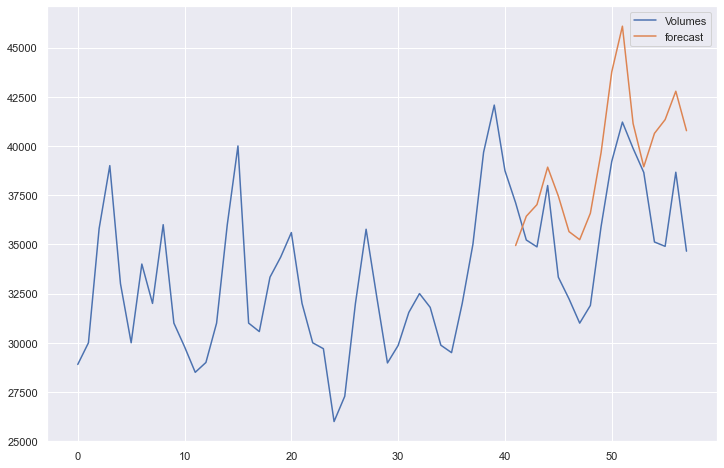

In [51]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_train_main['Volumes'],order=(1, 1, 2),seasonal_order=(1,1,2,12))
results=model.fit()
df_train_main['forecast']=results.predict(start=41,end=57,dynamic=True)
df_train_main[['Volumes','forecast']].plot(figsize=(12,8))

    The exogenous variable in time series is a parallel time series that is not explicitly modelled but is utilised as a weighted input to the model. For univariate time series having trend and/or seasonal components as well as exogenous factors, the technique is appropriate. Exogenous variables are those whose value is decided outside of the model and imposed on it. A problem like this can be solved using a variety of models, but we'll be using SARIMAX. Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors (SARIMAX) is an acronym for Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors.

    To determine if this new variable is exogenous, you must first determine whether the rise in output causes the new variables to alter. A variable like "weather" is clearly exogenous, because an increase in production has no influence on the weather.